In [102]:
import pandas as pd
import numpy as np
from plot_jzar import *
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [103]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

### We have 3 types of data:

- Independent features (clustered)
- `How good the route is (the higher the better)` => <b>In this notebook we will work on this one
- Grade, Location, sex, heigh (defined by user)


# Routes rating

Objective
- We want to convert all the "rating" columns into a single one

In [104]:
routes = pd.read_csv('../data/routes_clustered.csv',low_memory=False, index_col=0)
print(routes.shape)
routes.tail(3)

(54958, 13)


name_id country         crag     sector            name  ascents_count  \
54955    54955     zaf  van stadens  the beach   funky chicken              2   
54956    54956     zaf  van stadens  the beach  out of control              2   
54957    54957     zaf  van stadens  the beach      sheathless              2   

       repeat_sum  recommend_sum  tall_recommend_sum  grade_mean  \
54955         0.0            0.0                   0        38.0   
54956         0.0            0.0                   0        36.0   
54957         0.0            0.0                  -1        39.5   

       sentiment_mean  rating_mean  cluster  
54955             0.0          1.0        0  
54956             NaN          NaN        0  
54957             0.0          2.0        0

## Prepare the dataframe

We will use the following values
- rating_mean -> the mean value of the route rating
- repeat_rate -> the sum of times that the route have been repeated by the same person divided by ascensions
- recommend_rate -> times that the route has been recommended divided by ascensions
- sentiment_rate -> sentiment count divided by comments count

In [105]:
routes_rate = routes.copy()
routes_rate['repeat_rate'] = routes_rate.repeat_sum / routes_rate.ascents_count
routes_rate['recommend_rate'] = routes_rate.recommend_sum / routes_rate.ascents_count

routes_rate = routes_rate[['rating_mean','repeat_rate','recommend_rate','sentiment_mean']]
print(routes_rate.shape)
routes_rate.tail(3)

(54958, 4)


rating_mean  repeat_rate  recommend_rate  sentiment_mean
54955          1.0          0.0             0.0             0.0
54956          NaN          0.0             0.0             NaN
54957          2.0          0.0             0.0             0.0

Replace nan by mean

In [106]:
routes_rate.isna().sum()

rating_mean        5766
repeat_rate           0
recommend_rate        0
sentiment_mean    10404
dtype: int64

In [107]:
routes_rate.rating_mean = routes_rate.rating_mean.fillna(np.mean(routes_rate.rating_mean))

In [108]:
routes_rate.rating_mean.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

In [109]:
routes_rate.replace([np.inf, -np.inf], np.nan, inplace=True)
routes_rate.sentiment_mean = routes_rate.sentiment_mean.fillna(0)
routes_rate.sentiment_mean.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

In [110]:
routes_rate.sentiment_mean.value_counts()

 0.000000    54112
 0.458800       54
 0.229400       36
 0.152933       31
 0.255300       23
             ...  
 0.006822        1
 0.005281        1
 0.005153        1
-0.154943        1
 0.039060        1
Name: sentiment_mean, Length: 282, dtype: int64

In [111]:
routes_rate.repeat_rate.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

In [112]:
routes_rate.recommend_rate.hist()

<Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>

 #### Scale them

In [113]:
X = routes_rate.copy()
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../transformer/scaler_rating.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled_df.shape)
display(X_scaled_df.head(3))

(54958, 4)


rating_mean  repeat_rate  recommend_rate  sentiment_mean
0    -0.430612    -0.213393        0.613117       -0.073676
1    -0.888130    -0.213393        0.834556       -0.073676
2    -0.430612    -0.213393       -0.494076       -0.073676

## Group the 3 features into one

### Check the PCA

In [114]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.33394234, 0.25020467, 0.24854249, 0.1673105 ])

We see that we cannot get only one feature from this, it should be higher than 80%

#### Check the distribution

<IPython.core.display.Javascript object>


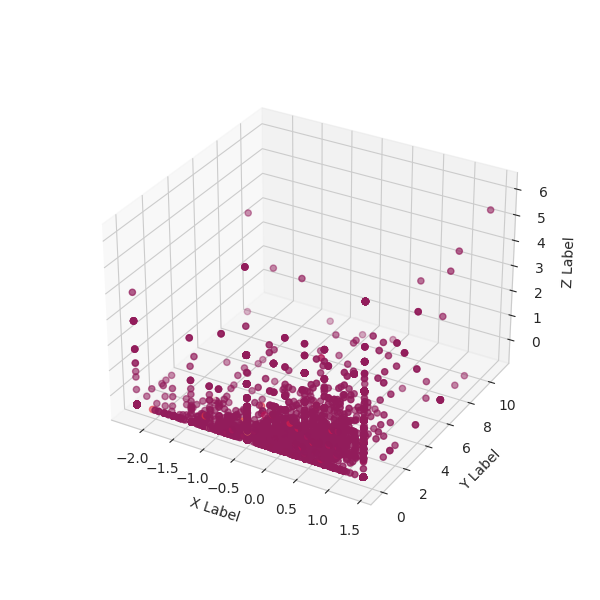

In [115]:
%matplotlib notebook
plot3D(x = X_scaled_df['rating_mean'],y = X_scaled_df['repeat_rate'],z = X_scaled_df['recommend_rate'],color = X_scaled_df['sentiment_mean'], fraction = 0.1)

### Mean

Just a simple mean gets the highest for a perfect rating in every feature, the lowest for the opposite

In [116]:
routes['rating_tot'] = (X_scaled_df.rating_mean + X_scaled_df.repeat_rate + X_scaled_df.recommend_rate + X_scaled_df.sentiment_mean)/4

In [117]:
routes = routes.drop(columns = ['repeat_sum','rating_mean','ascents_count','sentiment_mean','recommend_sum'])
routes.head()

name_id country        crag       sector                    name  \
0        0     and  montserrat  prohibitivo                el mehir   
1        1     and  montserrat  prohibitivo  el pas de la discordia   
2        2     and  montserrat  prohibitivo                    la x   
3        3     and    tartareu   bombo suis           tenedor libre   
4        4     arg  bandurrias       rincon              tendinitis   

   tall_recommend_sum  grade_mean  cluster  rating_tot  
0                  -1   49.000000        0   -0.026141  
1                   0   49.000000        0   -0.085161  
2                  -1   49.250000        0   -0.302939  
3                   0   44.333333        0    0.708176  
4                   1   48.500000        0   -0.760458

In [118]:
routes.to_csv('../data/routes_rated.csv')